# Import Libraries

In [39]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Data Collection

In [40]:
# Need to call out data import of either full data or filtered data
data = pd.read_csv(r"C:\Users\theni\Downloads\data\processed_data\aggregated_news.csv.gz")

C:\Users\theni\AppData\Local\Temp\ipykernel_94516\662086782.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\theni\Downloads\data\processed_data\aggregated_news.csv.gz")


In [98]:
# Remove the ' UTC' part and convert to datetime
data['timestamp_clean'] = pd.to_datetime(data['Date'].str.replace(' UTC', '', regex=False))

# Extract date and time
data['Release Date'] = data['timestamp_clean'].dt.date
data['Time'] = data['timestamp_clean'].dt.time

# Optional: drop the cleaned timestamp column if you don't need it
data = data.drop(columns='timestamp_clean')

In [99]:
data.head()

,Date,Article_title,Stock_symbols,Release Date,Time
0,1914-09-16 00:00:00 UTC,1914. Празднование столетия М.Ю. Лермонтова от...,NaN,1914-09-16,00:00:00
1,1914-09-16 00:00:00 UTC,1914. Русские войска вступили в пределы Венгрии,NaN,1914-09-16,00:00:00
2,1914-09-17 00:00:00 UTC,1914. Das ist Nesteroff!,NaN,1914-09-17,00:00:00
3,1914-09-17 00:00:00 UTC,1914. Бульдог-гонец под Льежем,NaN,1914-09-17,00:00:00
4,1914-09-18 00:00:00 UTC,1914. Под Люблином пойман швабский зверь,NaN,1914-09-18,00:00:00


In [102]:
data.shape

(12480047, 5)

In [105]:
# Filter out rows where time == 00:00:00
data_filtered = data[data['Time'] != pd.to_datetime('00:00:00').time()]

In [106]:
data_filtered.head()

,Date,Article_title,Stock_symbols,Release Date,Time
176138,2007-01-01 05:46:00 UTC,Kylie sees in 2007 with UK concert,NaN,2007-01-01,05:46:00
176139,2007-01-01 05:59:00 UTC,Thailand says Thaksin backers may be behind bl...,NaN,2007-01-01,05:59:00
176140,2007-01-01 06:09:00 UTC,Somali government vows to pursue fleeing Islam...,NaN,2007-01-01,06:09:00
176141,2007-01-01 06:29:00 UTC,"Japan TV apologizes for ""topless"" New Year's E...",NaN,2007-01-01,06:29:00
176142,2007-01-01 07:09:00 UTC,Hundreds hurt in New Year revelry in Philippines,NaN,2007-01-01,07:09:00


In [108]:
data_filtered.shape

(8437489, 5)

# Tokenize News Articles

In [151]:
X = data_filtered['Article_title'].to_list()
sentiment_output = [] # Stores predicted labels
sent_perc = [] # Stores sentiment probabilities
article = []

In [110]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Create Sentiment Feature

In [152]:
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    labels = ["Negative", "Neutral", "Positive"]
    sentiment = labels[torch.argmax(probabilities).item()]
    
    return sentiment, probabilities


In [153]:
for i in range(int(len(X)/100)):
    output = analyze_sentiment(X[i])  # Analyze sentiment
    sentiment_label = output[0]  # Extract predicted sentiment
    probabilities = output[1]  # Extract probability tensor

    # Append sentiment labels correctly
    sentiment_output.append(sentiment_label)
    article.append(X[i])
    
    # Extract and store the probability of the predicted class
    if sentiment_label == 'Positive':
        sent_perc.append(probabilities[0][2].item())
    elif sentiment_label == 'Negative':
        sent_perc.append(probabilities[0][0].item())
    else:  # Neutral case
        sent_perc.append(probabilities[0][1].item())


# Evaluation

In [154]:
from collections import Counter

sentiment_counts = Counter(sentiment_output)
print("Sentiment Distribution:", sentiment_counts)

Sentiment Distribution: Counter({'Positive': 45836, 'Neutral': 23220, 'Negative': 15318})


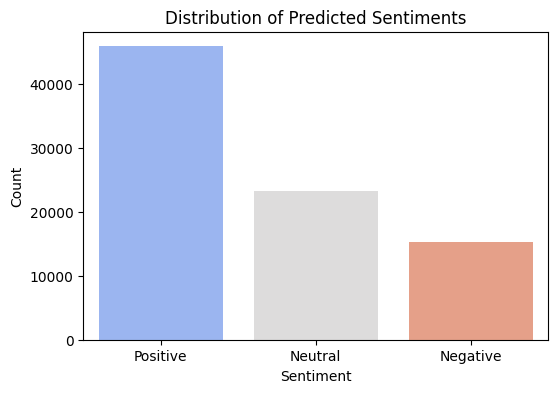

In [155]:
# Count occurrences of each sentiment
sentiment_df = pd.DataFrame({"Sentiment": sentiment_output})
sentiment_counts = sentiment_df["Sentiment"].value_counts()

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Predicted Sentiments")
plt.show()

In [157]:
df_results = pd.DataFrame({"Article": article, "Predicted Sentiment": sentiment_output, "Sentiment Score": sent_perc})

# Top 5 positive articles
top_positive = df_results[df_results["Predicted Sentiment"] == "Positive"].nlargest(5, "Sentiment Score")
print("Top Positive Sentiments:\n", top_positive)

# Top 5 negative articles
top_negative = df_results[df_results["Predicted Sentiment"] == "Negative"].nlargest(5, "Sentiment Score")
print("Top Negative Sentiments:\n", top_negative)

Top Positive Sentiments:
                                                  Article Predicted Sentiment  \
45986       Bankrupt YUKOS asset sales to begin in March            Positive   
79744   General Motors will not bid for Chrysler - paper            Positive   
15873  AMEX modifies transferring listing, dual listi...            Positive   
71397  Gramercy Capital sets up property securities unit            Positive   
15689   Synta sets IPO at 6 million shares, $14-$16 each            Positive   

       Sentiment Score  
45986         0.956492  
79744         0.955069  
15873         0.954894  
71397         0.954884  
15689         0.954883  
Top Negative Sentiments:
                                                  Article Predicted Sentiment  \
76276       Higher sales, margins boost Forzani's profit            Negative   
65989     Commscope boosts revenue and op margin targets            Negative   
5493   CORRECTED - CORRECTED-Digimarc sees higher rev...            Negative 

# Classification

In [171]:
change = []

In [173]:
for j in range(len(df_results["Article"])):
    if df_results["Predicted Sentiment"][j] == 'Positive' and df_results["Sentiment Score"][j] > 0.6:
        change.append("Trending Upwards")
    elif df_results["Predicted Sentiment"][j] == 'Negative' and df_results["Sentiment Score"][j] > 0.60:
        change.append("Trending Downwards")
    else:
        change.append("No Change Expected")
df_results["Expected Trend"] = change

In [175]:
trend_counts = df_results["Expected Trend"].value_counts()
print(trend_counts)

Expected Trend
Trending Upwards      41741
No Change Expected    29721
Trending Downwards    12912
Name: count, dtype: int64
